# Aula 7 - KNN e ferramentas especiais

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) KNN
- 2) Ferramentas Especiais
- 3) KNN para regressão

____
____
____

## 1) KNN

Hoje conheceremos um novo algoritmo de aprendizagem (que inicialmente veremos no contexto de classificação): o KNN, que é a sigla de **k nearest neighbors**, ou seja, **k vizinhos mais próximos**.

A ideia é bem simples: tomamos uma base de treino classificada (supervisionada). 

A cada observação de teste que queiramos classificar, tomamos **a classe como sendo a classe das $k$ observações que estão mais próximas do elemento a ser classificado**

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png" width=600>

Este algoritmo é muito simples e intuitivo, mas há dois elementos de extrema importância:

> Como medir a **distância** entre dados? Qual é a **métrica** adequada?

Veremos que o sklearn nos permite escolher diferentes métricas de distância, o que é ótimo, pois assim podemos seguir a habitual abordagem: testar diferentes métricas, e escolher a que der melhores resultados!

> Qual é o número de vizinhos adequados: i.e., **como escolher $k$?**

Essa é uma escolha particularmente importante, pois escolhas diferentes de $k$ podem facilmente levar a classificações diferentes:

<img src="https://helloacm.com/wp-content/uploads/2016/03/2012-10-26-knn-concept.png" width=400>

Veremos logo como escolher bons valores!

> **Reflita e responda**: como a escolha de $k$ influencia a performance de generalização do modelo (isto é, seu comportamento no que diz respeito ao trade-off viés-variância)?
><br><br>Dica: pense no que acontece nos extremos, $k=1$ e $k=N$, ond $N$ é o número de observações na base de treino.

Conclusão: 

- $k=1$ temos alta variância (overfitting - pense nos outliers!).

- $k=N$ temos alto viés (underfittinf - não aprendemos nada, só predizemos diretamente a classe majoritária na base de treino).

As etapas do algoritmo são as seguintes:

1. Recebe um dado não classificado;
2. Mede sua distância (Euclidiana, Manhattan, Minkowski ou Ponderada) de cada um dos elementos da base de treino;
3. Obtém um *ranking* das distâncias, em ordem decrescente;
4. Verifica a classe de cada da um dos *K* dados que tiveram a menor distância e conta a quantidade de cada classe;
5. Toma como resultado a classe que mais apareceu dentre os dados que tiveram as menores distâncias;
6. Classifica o novo dado com a classe tomada como resultado da classificação.

KNN é um método LAZY LEARNER -- Ou seja, **não há uma etapa explícita de treinamento**, conforme vimos antes.

Cada observação de teste é classificada por vez, segundo o passo a passo acima.

> **MUITO IMPORTANTE**: sempre devemos **escalar os dados** quando formos construir um modelo KNN! Reflita: por quê?

In [1]:
# importe as principais bibliotecas

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#### Lendo conjunto de dados

Como exemplo vamos utilizar dados de câncer de mama (o dataset que foi sugerido como exercício!), eles estão disponiveis no [UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) ou pelo [kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). 

A ideia é que consigamos construir um modelo para classificar, com base em medidas fisiológicas, se um tumor é maligno ou benigno.

In [2]:
df = pd.read_csv("breast_cancer.csv")

In [3]:
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

A coluna de ID não dá nenhuma informação relevante: podemos eliminá-la

In [5]:
df = df.drop(columns="id")

In [6]:
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [7]:
# dá pra ver que tem muita diferença de escala nas features! PRECISAMOS NORMALIZAR!!

df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [8]:
df.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Explore os dados! Essa é uma base muito rica, com muitas colunas! Aproveite este exemplo concreto para fazer muitas perguntas e respondê-las! Faça visualizações sempre que achar interessante!

Vamos fazer um apenas pra treinar:

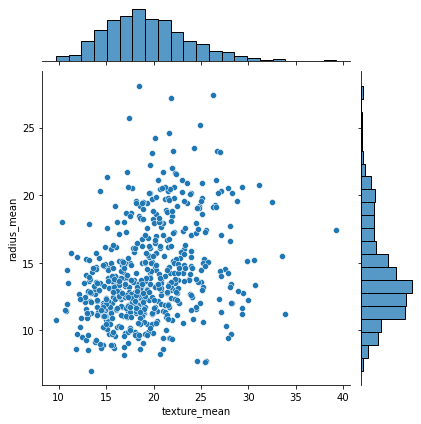

In [9]:
sns.jointplot(data=df, x="texture_mean", y="radius_mean")

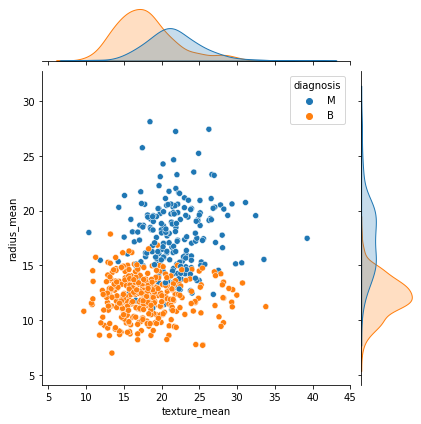

In [10]:
sns.jointplot(data=df, x="texture_mean", y="radius_mean", hue="diagnosis")

Uma pergunta é bastante importante:

In [11]:
df["diagnosis"].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [12]:
df["diagnosis"].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

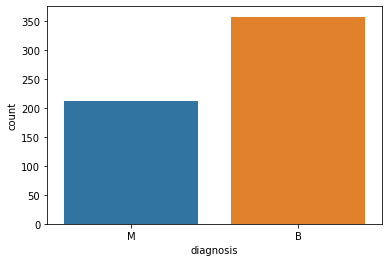

In [13]:
sns.countplot(data=df, x="diagnosis")

In [14]:
# isso equivale a usar o k=n

y_pred = df["diagnosis"].value_counts().index[0]

y_pred

'B'

Há um leve desbalanceamento: há mais dados de tumores benignos do que malignos. 

Como o desbalanceamento não é tão gritante assim (coisa de 80-20), e este desbalanço é algo natural, não vamos tratar este caso, vamos deixar para tratar um caso mais crítico.

[Clique aqui](https://machinelearningmastery.com/what-is-imbalanced-classification/) para saber um pouco mais sobre desbalanceamento de classes; e [aqui](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) caso você queira saber algumas formas de endereçar este problema (spoilers!).

Uma coisa importante é sempre setar o parâmetro `stratify` do train-test split, que vai garantir a mesma distribuição do target em ambos os conjuntos de treino e de teste! Isso faz com que a diferença na distribuição não se torne um fator adicional de viés na avaliação do modelo!

In [15]:
X = df.drop(columns="diagnosis")
y = df["diagnosis"]

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
y.value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [18]:
# atenção ao stratify!
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)

In [19]:
y_train.value_counts(normalize=True)

   

B    0.626374
M    0.373626
Name: diagnosis, dtype: float64

In [20]:
y_test.value_counts(normalize=True)

B    0.631579
M    0.368421
Name: diagnosis, dtype: float64

_____

**Transformando os dados**

O primeiro processo que pode ser feito para tunning do KNN é a **transformação das features**. 

Devido ao KNN utilizar **distâncias** como critério para classificação, ter as variaveis transformadas garante que sejam eliminados viéses relacionados à escala dos dados.

Para **normalizar os dados**, o sklearn nos apresenta a ferramenta [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

É **muito importante** que os transformers sejam fitados **com os dados de treino**, para que informações da base de teste não sejam utilizadas no treinamento (conceito conhecido como [data leakage](https://machinelearningmastery.com/data-preparation-without-data-leakage/)).

No caso do standard scaler: o objetivo do `.fit()` é determinar a média $\mu$ e desvio padrão $\sigma$ dos dados, para que a normalização seja feita. Se calcularmos estes parâmetros usando **todos os dados**, estamos utilizando informações da base de teste -- o que, como sabemos, jamais deve ser feito!!

Por isso, sempre siga o seguinte passo-a-passo par aplicação de transformers:

- Primeiro, faça o train test split;
- Use o `.fit()` nos dados de **treino**;
- Use o `.transform()` pra trasnformar os dados de treino e de teste tbm -- com o **mesmo transformer treinado** com os dados de treino;

Começaremos com o  [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) - **média 0 e std 1**

In [21]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [22]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.166077,19.417692,92.215868,659.578242,0.095993,0.103835,0.089184,0.049015,0.181497,0.062715,...,16.351514,25.904879,107.860484,890.569231,0.132083,0.255529,0.275166,0.115491,0.291364,0.084124
std,3.579081,4.290653,24.717118,360.418686,0.014310,0.053910,0.081698,0.039686,0.027646,0.006971,...,4.901037,6.079532,34.176019,582.346181,0.023481,0.158400,0.212066,0.066844,0.063043,0.018169
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.050240,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.710000,16.335000,75.235000,420.400000,0.085130,0.063735,0.029520,0.019685,0.162050,0.057635,...,13.020000,21.490000,84.135000,516.150000,0.114550,0.147750,0.119350,0.064075,0.251200,0.071365
50%,13.340000,18.900000,86.180000,546.400000,0.095240,0.092280,0.059400,0.033340,0.179900,0.061300,...,14.920000,25.480000,97.650000,683.400000,0.131100,0.216700,0.229800,0.101000,0.282300,0.080090
75%,15.935000,21.830000,104.500000,795.500000,0.104900,0.130350,0.132200,0.074075,0.195400,0.066370,...,19.185000,30.200000,127.000000,1122.500000,0.146600,0.338100,0.385700,0.162100,0.318700,0.092085
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [23]:
# tivemos que transformar num dataframe, pq o std scaler retorna arrays do numpy, que não têm o metodo describe

pd.DataFrame(X_train_ss, columns=X_train.columns).describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,...,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,-1.820278e-16,3.693017e-16,4.958183e-16,-1.049222e-16,1.141944e-16,-2.151972e-16,-1.908120e-16,4.245688e-17,5.368111e-18,9.882205e-18,...,-3.794279e-16,2.318048e-16,-2.820698e-16,-8.784182e-18,-2.200926e-16,-1.156584e-16,-5.856121e-17,-8.052167e-17,-4.902062e-16,-2.577913e-16
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,...,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00
min,-2.009730e+00,-2.265011e+00,-1.961360e+00,-1.433461e+00,-2.342455e+00,-1.568307e+00,-1.092835e+00,-1.236420e+00,-2.733834e+00,-1.791603e+00,...,-1.720204e+00,-2.286387e+00,-1.682868e+00,-1.212587e+00,-2.596976e+00,-1.442492e+00,-1.298977e+00,-1.729670e+00,-2.141576e+00,-1.602524e+00
25%,-6.869865e-01,-7.192578e-01,-6.877646e-01,-6.643427e-01,-7.599676e-01,-7.446452e-01,-7.311067e-01,-7.398554e-01,-7.042022e-01,-7.295506e-01,...,-6.805052e-01,-7.269867e-01,-6.949785e-01,-6.436573e-01,-7.475060e-01,-6.811748e-01,-7.355618e-01,-7.700379e-01,-6.377821e-01,-7.030095e-01
50%,-2.310610e-01,-1.207886e-01,-2.444667e-01,-3.143644e-01,-5.267576e-02,-2.145711e-01,-3.649669e-01,-3.954004e-01,-5.783428e-02,-2.031921e-01,...,-2.924054e-01,-6.996374e-02,-2.990905e-01,-3.561409e-01,-4.191078e-02,-2.454053e-01,-2.141609e-01,-2.170230e-01,-1.439281e-01,-2.222582e-01
75%,4.947835e-01,5.628428e-01,4.975359e-01,3.775369e-01,6.231343e-01,4.923801e-01,5.271006e-01,6.321626e-01,5.034376e-01,5.249492e-01,...,5.787764e-01,7.072664e-01,5.606441e-01,3.987080e-01,6.189186e-01,5.218523e-01,5.217957e-01,6.980537e-01,4.340876e-01,4.386715e-01
max,3.900239e+00,4.634299e+00,3.899731e+00,5.114742e+00,4.715773e+00,4.485809e+00,4.137033e+00,3.838961e+00,4.435961e+00,4.987148e+00,...,4.021630e+00,3.891934e+00,4.198771e+00,5.782013e+00,3.859114e+00,5.071677e+00,4.611335e+00,2.628551e+00,5.914120e+00,6.798089e+00


De fato, após o scaling, temos média zero e desvio padrão 1!

In [24]:
ss.mean_

array([1.41660769e+01, 1.94176923e+01, 9.22158681e+01, 6.59578242e+02,
       9.59929451e-02, 1.03834857e-01, 8.91842829e-02, 4.90145978e-02,
       1.81497143e-01, 6.27148132e-02, 4.11187253e-01, 1.21788198e+00,
       2.91156879e+00, 4.12791033e+01, 6.89525275e-03, 2.53234330e-02,
       3.20175508e-02, 1.16906176e-02, 2.04266989e-02, 3.76603802e-03,
       1.63515143e+01, 2.59048791e+01, 1.07860484e+02, 8.90569231e+02,
       1.32083033e-01, 2.55529473e-01, 2.75166367e-01, 1.15490705e-01,
       2.91363736e-01, 8.41236923e-02])

In [25]:
ss.scale_

array([3.57514584e+00, 4.28593536e+00, 2.46899415e+01, 3.60022403e+02,
       1.42939574e-02, 5.38509592e-02, 8.16081746e-02, 3.96423375e-02,
       2.76158525e-02, 6.96293458e-03, 2.89863734e-01, 5.51704871e-01,
       2.12078456e+00, 4.83309757e+01, 2.85147076e-03, 1.76046647e-02,
       3.16943985e-02, 6.28235072e-03, 8.30145216e-03, 2.62910285e-03,
       4.89564848e+00, 6.07284725e+00, 3.41384425e+01, 5.81705888e+02,
       2.34553735e-02, 1.58225864e-01, 2.11833144e-01, 6.67703567e-02,
       6.29740748e-02, 1.81486759e-02])

In [26]:
# tbm podemos aplicar a transformação inversa
ss.inverse_transform(X_train_ss)

array([[1.602e+01, 2.324e+01, 1.027e+02, ..., 9.975e-02, 2.948e-01,
        8.452e-02],
       [1.232e+01, 1.239e+01, 7.885e+01, ..., 9.391e-02, 2.827e-01,
        6.771e-02],
       [1.285e+01, 2.137e+01, 8.263e+01, ..., 5.601e-02, 2.488e-01,
        8.151e-02],
       ...,
       [1.300e+01, 2.513e+01, 8.261e+01, ..., 5.921e-02, 2.306e-01,
        6.291e-02],
       [1.420e+01, 2.053e+01, 9.241e+01, ..., 1.339e-01, 2.534e-01,
        7.858e-02],
       [1.706e+01, 2.100e+01, 1.118e+02, ..., 1.827e-01, 2.623e-01,
        7.599e-02]])

### Exercício

Vamos fazer a predição do dataset dos penguins novamente, fazendo a classificação por ilha (que não tinha performado tão bem)

1 - Instancie o Standard Scaler

2 - Faça o fit transform dos dados de treino e o transform dos dados de teste

3 - Faça o fit com os dados escalados, e o target não escalado

4 - Gere a predição com os dados de teste escalados

5 - Analise as metricas usando matriz de confusão e classification report

In [27]:
penguin = sns.load_dataset('penguins')

In [28]:
penguin.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [29]:
penguin.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


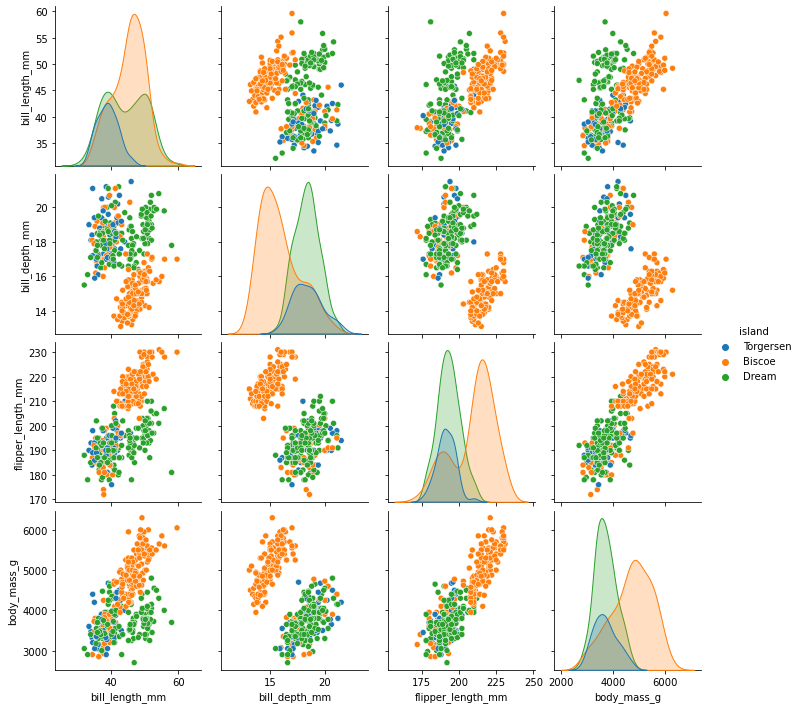

In [30]:
sns.pairplot(penguin, hue='island')

## Outros Scalers

Outra opção é transformar os dados com o [min max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - **deixa o espaço amostral entre 0 e 1**

Aqui, as mesmas considerações sobre o método `.fit()` são válidas! (E pra qualquer outro transformer)

In [31]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

In [32]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.166077,19.417692,92.215868,659.578242,0.095993,0.103835,0.089184,0.049015,0.181497,0.062715,...,16.351514,25.904879,107.860484,890.569231,0.132083,0.255529,0.275166,0.115491,0.291364,0.084124
std,3.579081,4.290653,24.717118,360.418686,0.014310,0.053910,0.081698,0.039686,0.027646,0.006971,...,4.901037,6.079532,34.176019,582.346181,0.023481,0.158400,0.212066,0.066844,0.063043,0.018169
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.050240,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.710000,16.335000,75.235000,420.400000,0.085130,0.063735,0.029520,0.019685,0.162050,0.057635,...,13.020000,21.490000,84.135000,516.150000,0.114550,0.147750,0.119350,0.064075,0.251200,0.071365
50%,13.340000,18.900000,86.180000,546.400000,0.095240,0.092280,0.059400,0.033340,0.179900,0.061300,...,14.920000,25.480000,97.650000,683.400000,0.131100,0.216700,0.229800,0.101000,0.282300,0.080090
75%,15.935000,21.830000,104.500000,795.500000,0.104900,0.130350,0.132200,0.074075,0.195400,0.066370,...,19.185000,30.200000,127.000000,1122.500000,0.146600,0.338100,0.385700,0.162100,0.318700,0.092085
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [33]:
pd.DataFrame(X_train_mms, columns=X_train.columns).describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,0.340058,0.328295,0.334641,0.218909,0.331876,0.259048,0.208960,0.243611,0.381299,0.264297,...,0.299591,0.370066,0.286122,0.173361,0.402252,0.221439,0.219781,0.396875,0.265846,0.190763
std,0.169392,0.145102,0.170804,0.152882,0.141835,0.165359,0.191420,0.197246,0.139628,0.147682,...,0.174352,0.162034,0.170208,0.143125,0.155063,0.153680,0.169382,0.229704,0.124272,0.119170
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.223816,0.224045,0.217297,0.117455,0.224205,0.136050,0.069166,0.097838,0.283081,0.156674,...,0.181074,0.252399,0.167962,0.081338,0.286469,0.116871,0.095327,0.220189,0.186675,0.107077
50%,0.300961,0.310788,0.292931,0.170901,0.324413,0.223606,0.139175,0.165706,0.373232,0.234322,...,0.248666,0.358742,0.235271,0.122444,0.395760,0.183767,0.183546,0.347079,0.247979,0.164305
75%,0.423778,0.409875,0.419529,0.276564,0.420161,0.340378,0.309747,0.368166,0.451515,0.341737,...,0.400391,0.484542,0.381443,0.230363,0.498118,0.301549,0.308067,0.557045,0.319732,0.242982
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
pd.DataFrame(X_test_mms, columns=X_test.columns).describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,...,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,0.330896,0.306682,0.326127,0.208981,0.350049,0.266797,0.204458,0.241243,0.372847,0.273052,...,0.284974,0.339781,0.271226,0.161110,0.411664,0.215316,0.207910,0.381705,0.253172,0.184940
std,0.156456,0.146208,0.156379,0.134243,0.128794,0.148317,0.167744,0.175040,0.134064,0.157426,...,0.162164,0.169294,0.155570,0.126502,0.132663,0.149022,0.155522,0.210471,0.112169,0.116011
min,0.036869,0.037538,0.028540,0.015907,-0.097928,0.051408,0.000000,0.000000,0.054040,-0.005932,...,0.036357,0.074627,0.031077,0.013493,0.090273,0.026351,0.000000,0.000000,0.017150,0.015283
25%,0.218964,0.203331,0.212028,0.114411,0.260110,0.154354,0.072229,0.108822,0.280429,0.182309,...,0.176005,0.202092,0.167650,0.080073,0.327082,0.114009,0.079762,0.226014,0.171348,0.110537
50%,0.305220,0.289990,0.296386,0.175907,0.352463,0.237163,0.165300,0.174230,0.358081,0.254979,...,0.250623,0.326359,0.239877,0.124717,0.420194,0.167128,0.174161,0.335498,0.246008,0.159550
75%,0.393843,0.388231,0.401907,0.242587,0.443205,0.342755,0.276418,0.347751,0.458081,0.331038,...,0.345607,0.443164,0.330768,0.191979,0.472859,0.306303,0.298602,0.550172,0.312488,0.241522
max,0.762412,0.769699,0.748462,0.652598,0.647140,0.680694,0.743674,0.776342,0.850000,0.964195,...,0.813234,0.889925,0.802281,0.638223,0.854718,0.878433,0.677955,0.873540,0.709836,0.587433


Podemos testar também o [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html):

In [35]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler().fit(X_train)

X_train_rs = rs.transform(X_train)
X_test_rs = rs.transform(X_test)

In [36]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.166077,19.417692,92.215868,659.578242,0.095993,0.103835,0.089184,0.049015,0.181497,0.062715,...,16.351514,25.904879,107.860484,890.569231,0.132083,0.255529,0.275166,0.115491,0.291364,0.084124
std,3.579081,4.290653,24.717118,360.418686,0.014310,0.053910,0.081698,0.039686,0.027646,0.006971,...,4.901037,6.079532,34.176019,582.346181,0.023481,0.158400,0.212066,0.066844,0.063043,0.018169
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.050240,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.710000,16.335000,75.235000,420.400000,0.085130,0.063735,0.029520,0.019685,0.162050,0.057635,...,13.020000,21.490000,84.135000,516.150000,0.114550,0.147750,0.119350,0.064075,0.251200,0.071365
50%,13.340000,18.900000,86.180000,546.400000,0.095240,0.092280,0.059400,0.033340,0.179900,0.061300,...,14.920000,25.480000,97.650000,683.400000,0.131100,0.216700,0.229800,0.101000,0.282300,0.080090
75%,15.935000,21.830000,104.500000,795.500000,0.104900,0.130350,0.132200,0.074075,0.195400,0.066370,...,19.185000,30.200000,127.000000,1122.500000,0.146600,0.338100,0.385700,0.162100,0.318700,0.092085
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [37]:
pd.DataFrame(X_train_rs, columns=X_train.columns).describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,0.195521,0.094212,0.206249,0.301728,0.038085,0.173457,0.290069,0.288189,0.047890,0.161971,...,0.232200,0.048781,0.238201,0.341666,0.030672,0.203990,0.170326,0.147827,0.134278,0.194676
std,0.847120,0.780829,0.844597,0.960860,0.723808,0.809281,0.795656,0.729656,0.828973,0.798008,...,0.794978,0.697994,0.797294,0.960413,0.732642,0.832151,0.796194,0.681906,0.933976,0.876865
min,-1.505089,-1.672429,-1.448488,-1.074114,-1.655539,-1.094348,-0.578496,-0.612980,-2.215892,-1.266171,...,-1.133820,-1.545350,-1.102065,-0.821638,-1.869891,-0.995062,-0.862775,-1.030349,-1.863704,-1.208977
25%,-0.385799,-0.466788,-0.373996,-0.335910,-0.511381,-0.428507,-0.291001,-0.251057,-0.535232,-0.419576,...,-0.308191,-0.458094,-0.315292,-0.275831,-0.516381,-0.362227,-0.414680,-0.376690,-0.460741,-0.421091
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.614201,0.533212,0.626004,0.664090,0.488619,0.571493,0.708999,0.748943,0.464768,0.580424,...,0.691809,0.541906,0.684708,0.724169,0.483619,0.637773,0.585320,0.623310,0.539259,0.578909
max,3.495858,3.708826,3.496327,5.210877,3.447648,3.799745,3.578107,3.086229,3.721139,4.137378,...,3.425791,2.762342,3.582177,5.888678,2.854914,4.419753,3.837807,1.938281,5.651852,6.149131


Agora sim, estamos prontos para treinar e avaliar o modelo, com as features escaladas!

Classe: [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

[[71  1]
 [ 4 38]]


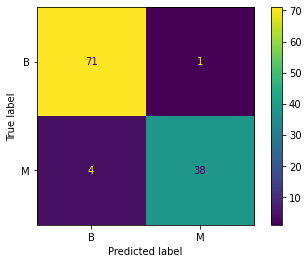

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


# ====================

[[284   1]
 [  9 161]]


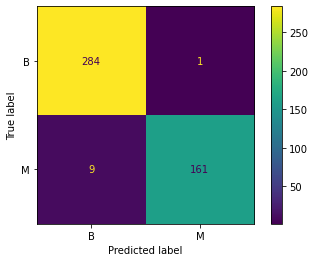

              precision    recall  f1-score   support

           B       0.97      1.00      0.98       285
           M       0.99      0.95      0.97       170

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.98       455
weighted avg       0.98      0.98      0.98       455



In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ====================

df = pd.read_csv("breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

knn = KNeighborsClassifier().fit(X_train_ss, y_train)

# ====================

y_pred_test = knn.predict(X_test_ss)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

print("\n# ====================\n")

y_pred_train = knn.predict(X_train_ss)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

Entendendo a classificação

In [39]:
# vamos pegar a primeira observação de teste, como exemplo
X_test_ss[0]

array([-0.24307384, -0.77089916, -2.00602473, -0.76451652, -0.71183971,
       -0.1583148 , -0.68680034, -0.66248612, -0.57475415, -0.53582061,
       -0.22760708, -0.93280815, -1.37244026, -0.85278289, -0.6368401 ,
       -0.2999339 , -0.56993036, -0.53250895, -0.83258923, -0.8416237 ,
       -0.59337276, -0.72135781, -1.63595077, -0.70654903, -0.65337009,
        0.96851866, -0.10446758, -0.30668651, -0.38805702,  0.16254727,
        0.06095804])

In [40]:
knn.predict(X_test_ss[0].reshape(1, -1))

array(['B'], dtype=object)

In [41]:
knn.kneighbors(X_test_ss[0].reshape(1, -1))

(array([[1.59659162, 1.91559863, 2.00607687, 2.0694831 , 2.07061232]]),
 array([[236, 164, 428,  98,  34]]))

In [42]:
X_train.iloc[[236, 164, 428,  98,  34]]

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
271,8910748,11.29,13.04,72.23,388.0,0.09834,0.07608,0.03265,0.02755,0.1769,...,12.32,16.18,78.27,457.5,0.1358,0.1507,0.12750,0.08750,0.2733,0.08022
48,857155,12.05,14.63,78.04,449.3,0.10310,0.09092,0.06592,0.02749,0.1675,...,13.76,20.70,89.88,582.6,0.1494,0.2156,0.30500,0.06548,0.2747,0.08301
527,91813702,12.34,12.27,78.94,468.5,0.09003,0.06307,0.02958,0.02647,0.1689,...,13.61,19.27,87.22,564.9,0.1292,0.2074,0.17910,0.10700,0.3110,0.07592
158,871122,12.06,12.74,76.84,448.6,0.09311,0.05241,0.01972,0.01963,0.1590,...,13.14,18.41,84.08,532.8,0.1275,0.1232,0.08636,0.07025,0.2514,0.07898
390,90317302,10.26,12.22,65.75,321.6,0.09996,0.07542,0.01923,0.01968,0.1800,...,11.38,15.65,73.23,394.5,0.1343,0.1650,0.08615,0.06696,0.2937,0.07722


In [43]:
y_train.iloc[[236, 164, 428,  98,  34]]

271    B
48     B
527    B
158    B
390    B
Name: diagnosis, dtype: object

## Exercício

Utilize o dataset de Insurance com as categorias criadas abaixo, faça o treinamento do K vizinhos para as classes escolhidas usando os Scalers que acabamos de conhecer e compare a performance

### Passo a passo

1 - Escolha um Scaler e faça o instanciamento

2 - Faça o fit transform dos dados de treino e o transform dos dados de teste

3 - Faça o fit com os dados escalados, e o target não escalado

4 - Gere a predição com os dados de teste escalados

5 - Analise as metricas usando matriz de confusão e classification report

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
df = pd.read_csv("insurance.csv")

In [57]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [58]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [59]:
df['target'] = np.where(df['charges'] < 10000, 0, np.where(df['charges'] < 30000, 1, 2))

In [60]:
## Cuidado com o vazamento

df.drop(['charges'], axis=1)

,age,sex,bmi,children,smoker,region,target
0,19,female,27.900,0,yes,southwest,1
1,18,male,33.770,1,no,southeast,0
2,28,male,33.000,3,no,southeast,0
3,33,male,22.705,0,no,northwest,1
4,32,male,28.880,0,no,northwest,0
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,1
1334,18,female,31.920,0,no,northeast,0
1335,18,female,36.850,0,no,southeast,0
1336,21,female,25.800,0,no,southwest,0


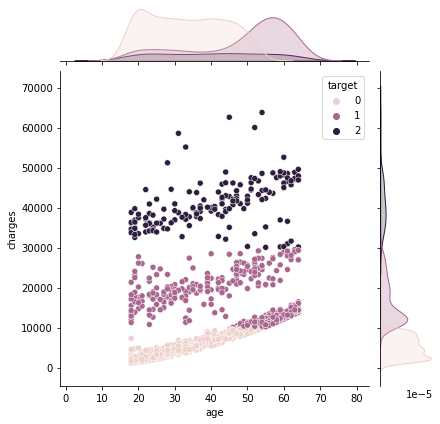

In [61]:
sns.jointplot(data=df, x='age', y='charges', hue='target');

In [51]:
## Você continua a partir daqui!

In [64]:
df_filtered = df.select_dtypes(include='number')
df_filtered = df_filtered.dropna()

In [88]:
df_filtered

,age,bmi,children,charges,target
0,19,27.900,0,16884.92400,1
1,18,33.770,1,1725.55230,0
2,28,33.000,3,4449.46200,0
3,33,22.705,0,21984.47061,1
4,32,28.880,0,3866.85520,0
...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1
1334,18,31.920,0,2205.98080,0
1335,18,36.850,0,1629.83350,0
1336,21,25.800,0,2007.94500,0


In [87]:
df

,age,sex,bmi,children,smoker,region,charges,target
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,1
4,32,male,28.880,0,no,northwest,3866.85520,0
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1
1334,18,female,31.920,0,no,northeast,2205.98080,0
1335,18,female,36.850,0,no,southeast,1629.83350,0
1336,21,female,25.800,0,no,southwest,2007.94500,0


Confusion Matrix
[[138   5   0]
 [ 10  83   0]
 [  0   4  28]]


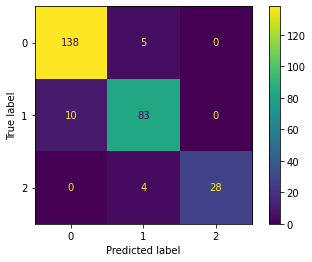

Classification Report

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       143
           1       0.90      0.89      0.90        93
           2       1.00      0.88      0.93        32

    accuracy                           0.93       268
   macro avg       0.94      0.91      0.93       268
weighted avg       0.93      0.93      0.93       268


# ====================

Confusion Matrix

[[563   6   0]
 [ 13 357   1]
 [  0   6 124]]


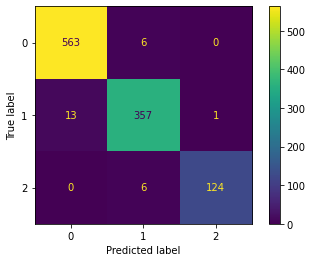

Classification Report

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       569
           1       0.97      0.96      0.96       371
           2       0.99      0.95      0.97       130

    accuracy                           0.98      1070
   macro avg       0.98      0.97      0.97      1070
weighted avg       0.98      0.98      0.98      1070



In [85]:
X = df_filtered.drop(columns="target")
y = df_filtered["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

knn = KNeighborsClassifier().fit(X_train_ss, y_train)

# ====================

y_pred_test = knn.predict(X_test_ss)

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_test))


ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print('Classification Report\n')
print(classification_report(y_test, y_pred_test))

print("\n# ====================\n")

y_pred_train = knn.predict(X_train_ss)

print('Confusion Matrix\n')
print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print('Classification Report\n')
print(classification_report(y_train, y_pred_train))

## Validação cruzada no KNN

__________

Vamos fazer também a validação cruzada!

Mas uma importante alteração é necessária... Se fizermos como antes, usando o target original diretamente:

```python
from sklearn.model_selection import KFold, cross_validate

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "f1"

results = cross_validate(estimator=estimador,
                         X=X_train, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)
```
Teremos um erro (teste!)

In [ ]:
from sklearn.model_selection import KFold, cross_validate

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimador = KNeighborsClassifier()

# ====================

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "f1"

results = cross_validate(estimator=estimador,
                         X=X_train, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

Não há problema algum em utilizar as classes originais quando deseja-se avaliar o modelo final com a matriz de confusão ou o classification_report. Internamente, é feita um mapeamento pra 0 e 1.

Mas, pra usar o cross_validate, este mapa não é feito. Daí, é necessário que seja explicitamente indicada este mapeamento. Pra fazer isso, há duas opções:

- 1 - Fazer o mapeamento explicitamente e depois usar o código extamente como acima;
- 2 - Indicar qual é a classe positiva (valor 1) na hora de indicar a métrica a ser calculada -- mas pra isso, a função respectiva da métrica deve ser usada, junto com o argumento `pos_label`

Vejamos ambas as opções:

In [ ]:
y.map({"M":1, "B":0})

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================
# alterando o target

y_num = y.map({"M":1, "B":0})

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y_num, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimador = KNeighborsClassifier()

# ====================

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "f1"

results = cross_validate(estimator=estimador,
                         X=X_train_ss, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

pd.DataFrame(results)

Segunda forma, só indicando o que é a classe positiva:

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimador = KNeighborsClassifier()

# ====================

grupo = KFold(n_splits=10, shuffle=True, random_state=42)


from sklearn.metrics import make_scorer, f1_score

metrica = make_scorer(f1_score, pos_label="M")

results = cross_validate(estimator=estimador,
                         X=X_train_ss, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

pd.DataFrame(results)

Discutimos que o recall da classe "M" é o que queremos otimizar. Então, vamos, antes de tudo, fazer a CV pra essa métrica:

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimador = KNeighborsClassifier()

# ====================

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

from sklearn.metrics import make_scorer, recall_score

metrica = make_scorer(recall_score, pos_label="M")

results = cross_validate(estimator=estimador,
                         X=X_train_ss, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

df_results = pd.DataFrame(results)

In [ ]:
df_results

In [ ]:
df_results.describe()

O modelo não teve uma performance muito ruim, mas podemos melhorar! Afinal, um modelo de tamanha importância não pode ter uma margem de erro muito grande, não é mesmo?

Vamos iniciar o ciclo de melhorias para ver se conseguimos melhorar a performance do modelo, em um processo que é muitas vezes chamado de **tunning**


**Novamente:** treine os scalers **apenas nos dados de treino** para evitar que informação dos dados de teste sejam passadas para o scaler! (Mais informações [aqui](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data))

Observe como a performance do modelo mudou!

Mas será que é possível melhorar ainda mais? Na aula que vem vamos agora aprender como é possível testar diferentes parâmetros de uma única vez!